# EWE8044 

## Homework #3

*2019170229 Bae Jiun*

<small>*Updated 2019/11/06*</small>

### Objective

1. Vector quantization
    
2. KL-distance

## vector quantization

Convert the image to grayscale and extract 8 * 8 patches (about 1 million).
Reshape this patch to (64,) to make a feature, and then perform k-means clustering 10, 20, 30, 40 times to analyze codeward and entropy changes.


In [1]:
from pathlib import Path

import numpy as np
from skimage import io, color, transform
from PIL import Image

In [2]:
image = (color.rgb2gray(io.imread('cat.jpg')) * 255).astype(np.uint8)
h, w, *_ = image.shape

#### Visualize image

In [3]:
from IPython.display import display

def show(ary):
    display(Image.fromarray(ary))

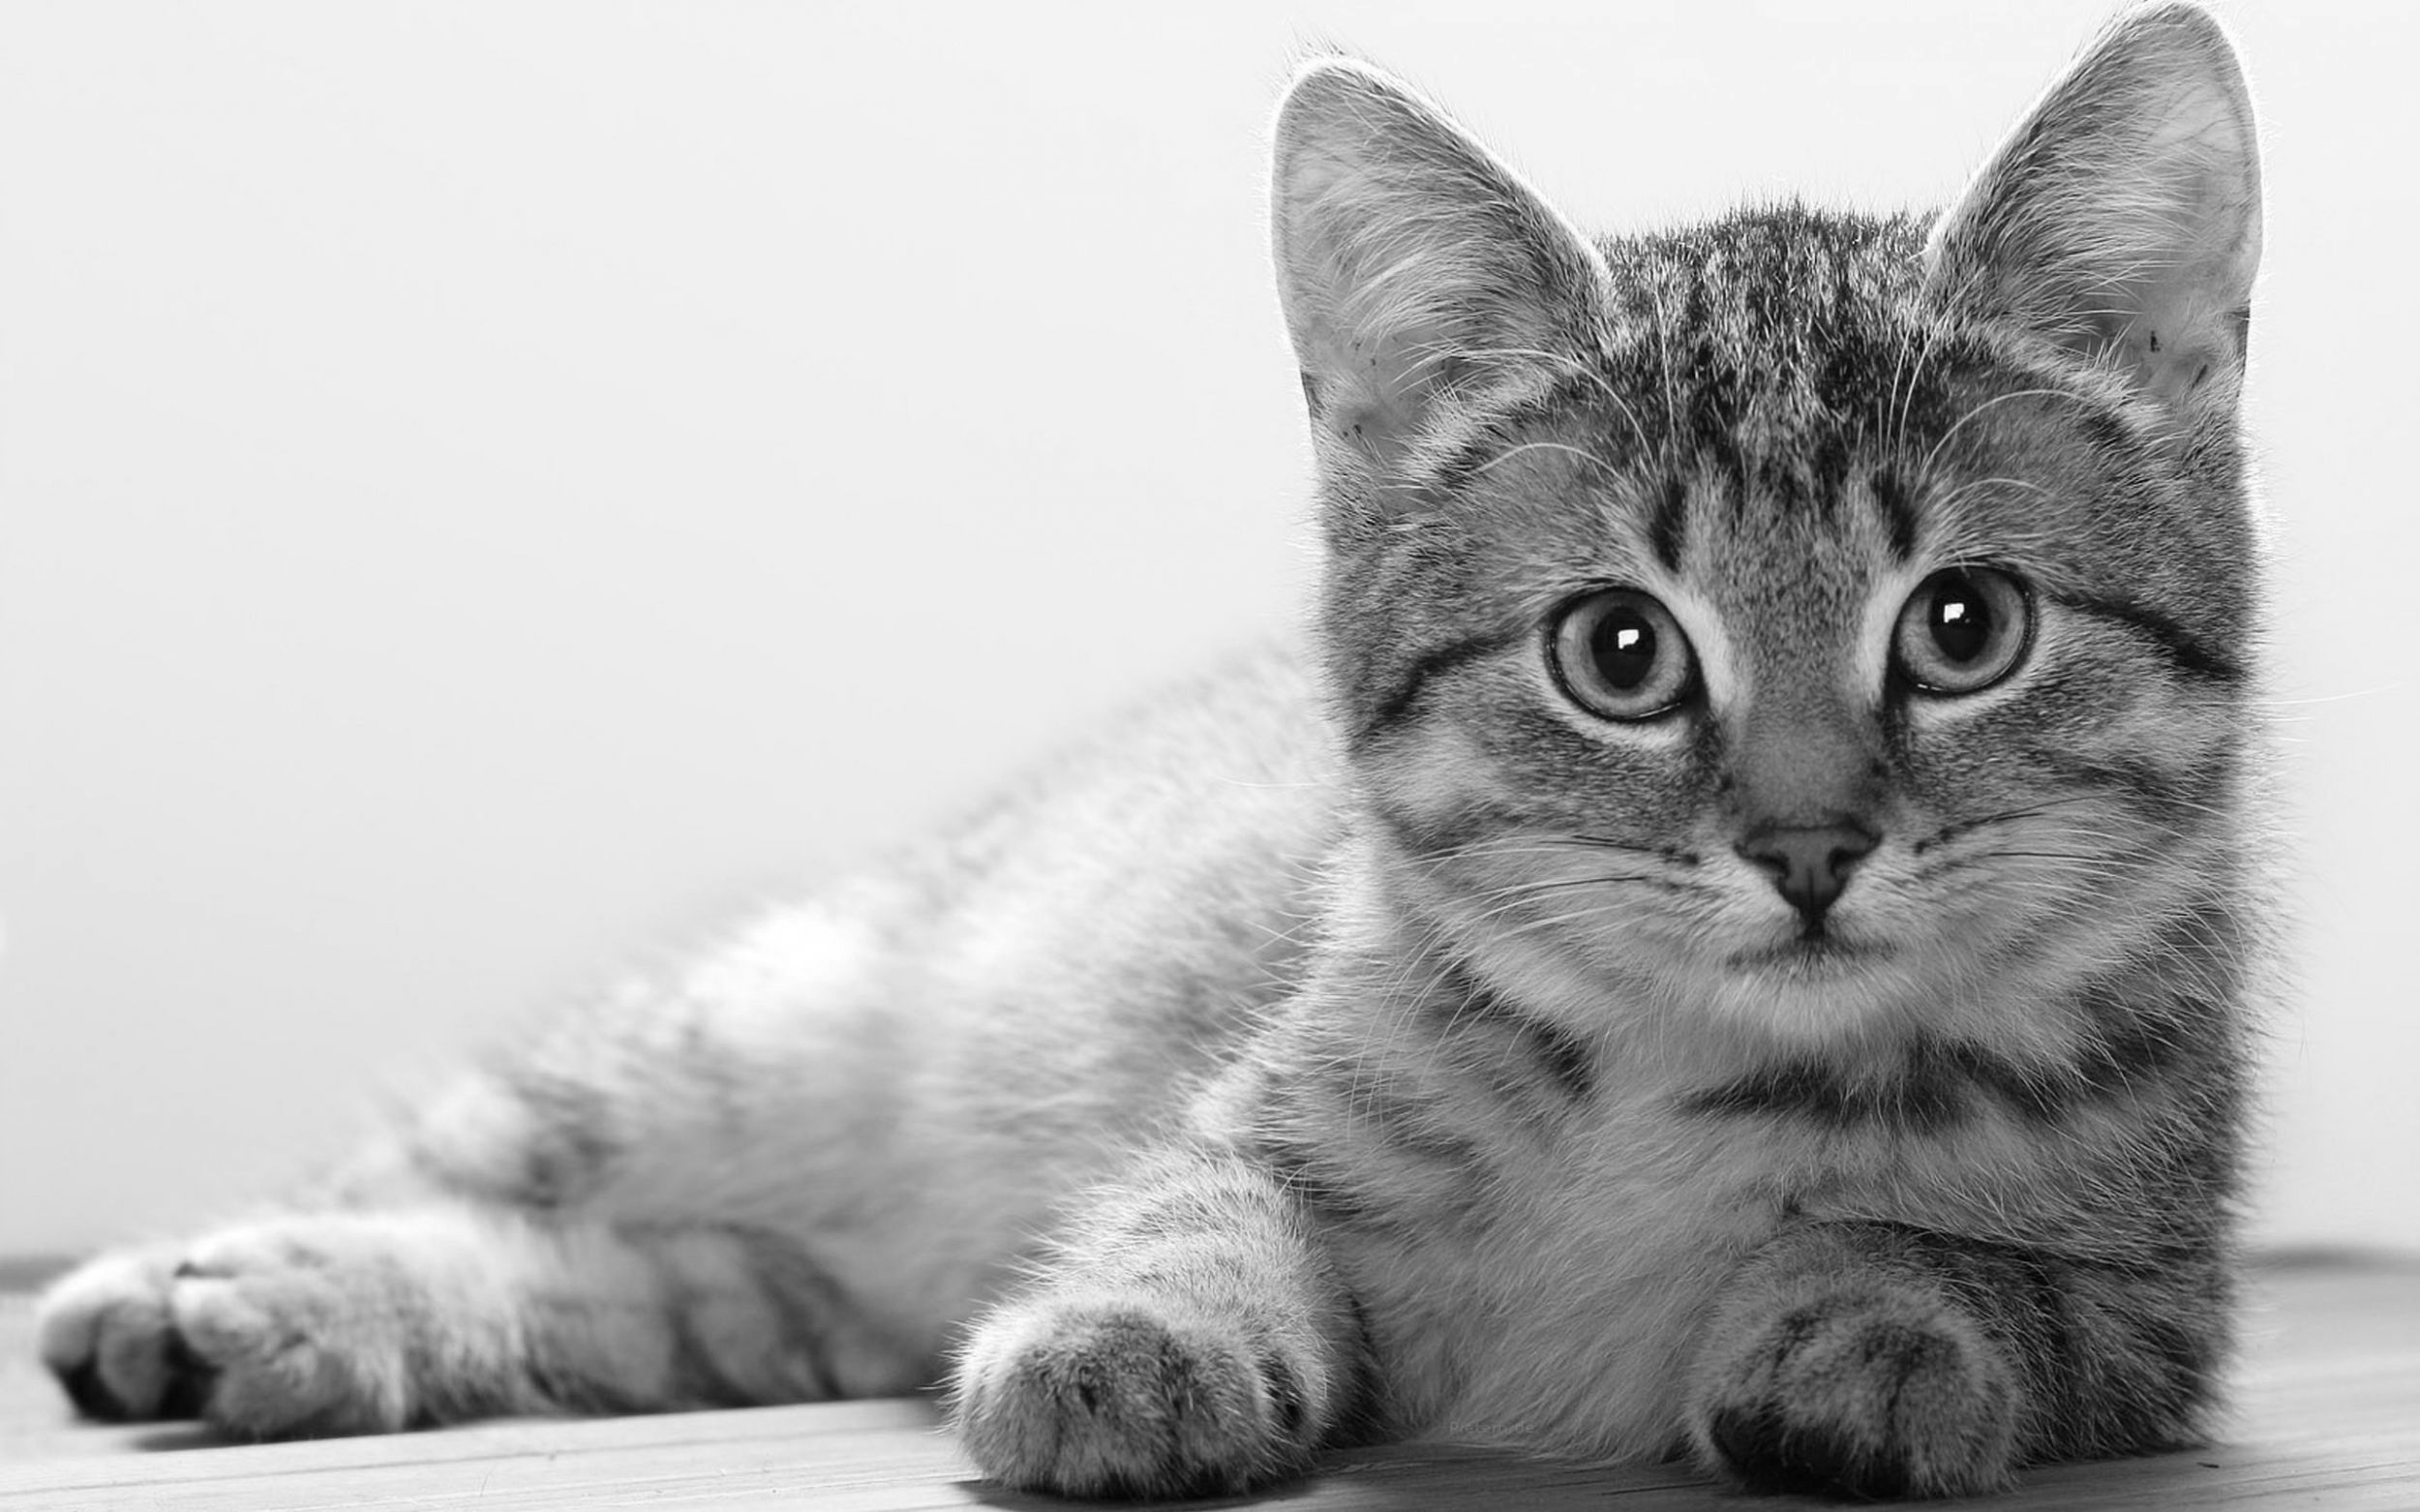

In [4]:
show(image)

#### Patch extraction

In [5]:
patch_counts = 10000
crop_size = np.array((8, 8))
patches = np.empty((patch_counts, *crop_size))

In [6]:
def extract(image, x, y, w=crop_size[0], h=crop_size[1]):
    return image[y:y+h, x:x+w]

In [7]:
for i in range(patch_counts):
    patches[i] = extract(image, np.random.randint(w-crop_size[0]), np.random.randint(h-crop_size[1]))

In [8]:
vsize = np.array((16, 128))
showcase = np.zeros((crop_size * vsize), dtype=np.uint8)
axis = np.random.choice(np.arange(patch_counts), vsize.prod(), replace=False)

In [9]:
for i, img in enumerate(patches[axis]):
    x, y = int(i % vsize[1]), int(i / vsize[1])
    showcase[y*crop_size[1]:(y+1)*crop_size[1], x*crop_size[0]:(x+1)*crop_size[0]] = img

16 x 128


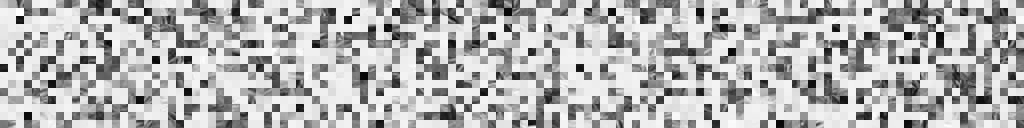

In [10]:
print(' x '.join(map(str, vsize)))
show(showcase)

#### Entropy analysis

In [11]:
def entropy(feature: np.ndarray, bins=256):
    histogram = np.histogramdd(np.ravel(feature), bins=bins)[0] / feature.size
    histogram = histogram[histogram > 0]
    return -np.sum(np.multiply(histogram, np.log2(histogram)))

In [12]:
features = patches.reshape(patch_counts, -1)

In [13]:
print(f'Entropy of features: {entropy(features):.4f}')

Entropy of features: 7.0390


In [14]:
from sklearn.cluster import KMeans

In [15]:
for it in [10, 20, 30, 40]:
    model = KMeans(n_clusters=2000, max_iter=it)
    model.fit(features)
    
    print(f'Entropy (iter={it}): {entropy(model.labels_, 2000):.4f}')

Entropy (iter=10): 8.0473
Entropy (iter=20): 8.0164
Entropy (iter=30): 8.0181
Entropy (iter=40): 8.0255


## KL-distance

Create points with 4 probability distributions (some class overlapping each other).

Perform k-means clustering to analyze how KL-dist is related to going from class A to class B as a new mean value.

KL-dist is not symmetric, so consider only (A, B) (A, C) (A, D) (B, C) (B, D) (C, D).

#### Generate random points

In [16]:
np.random.seed(8044)

In [17]:
points = { k: np.random.normal(
    loc=(np.random.randint(100), np.random.randint(100)), 
    scale=(np.random.uniform(.1, 10.), np.random.uniform(.1, 10.)),
    size=(10000,2),
).astype(np.int8) for k in 'ABCD'}

#### Visualize points

In [18]:
import matplotlib.pyplot as plt

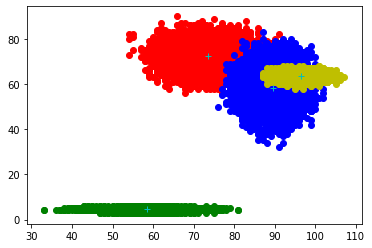

In [19]:
for (k, v), c in zip(points.items(), ['r', 'g', 'b', 'y']):
    plt.scatter(v[:, 0], v[:, 1], color=c)

for x, y in map(lambda x: x.mean(0) ,points.values()):
    plt.plot(x, y, marker='+', color='c')
plt.show()

#### Calculate KL distances

In [20]:
from itertools import combinations

In [21]:
def KL(source, target, epsilon=1e-8):
    return np.sum(source * np.log((source + epsilon) / (target + epsilon)))

In [35]:
total = []
for s, t in combinations('ABCD', 2):
    total.append(KL(points[s].mean(0)/100, points[t].mean(0)/100))
    print(f'Distance {s}-{t}: {total[-1]:.4f}')
print(f'total distance mean: {np.array(total).mean():.4f},\t std: {np.array(total).std():.4f}')

Distance A-B: 2.1844
Distance A-C: 0.0128
Distance A-D: -0.1031
Distance B-C: -0.3640
Distance B-D: -0.4120
Distance C-D: -0.1162
total distance mean: 0.2003,	 std: 0.8998


#### K-means clustering

In [23]:
from scipy.cluster.vq import kmeans

In [30]:
features = np.array(list(points.values())).reshape(-1, 2)

In [31]:
codebook, distortion = kmeans(features / 100, 4)

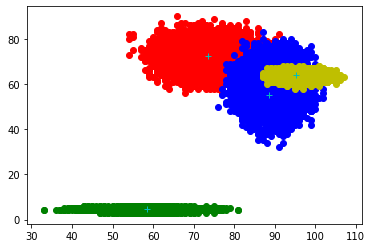

In [32]:
for (k, v), c in zip(points.items(), ['r', 'g', 'b', 'y']):
    plt.scatter(v[:, 0], v[:, 1], color=c)
    
for x, y in codebook*100:
    plt.plot(x, y, marker='+', color='c')
    
plt.show()

#### KL distances after clustering

In [33]:
next_mean = {}
for k, v in points.items():
    point = v.mean(0)
    dists = [(np.linalg.norm(point - new_point), new_point) for new_point in codebook*100]
    next_mean[k] = sorted(dists, key=lambda x: x[0])[0][1]

In [36]:
total = []
for s, t in combinations('ABCD', 2):
    total.append(KL(next_mean[s].mean(0)/100, next_mean[t].mean(0)/100))
    print(f'Distance {s}-{t}: {total[-1]:.4f}')
print(f'total distance mean: {np.array(total).mean():.4f},\t std: {np.array(total).std():.4f}')

Distance A-B: 0.6148
Distance A-C: 0.0108
Distance A-D: -0.0627
Distance B-C: -0.2604
Distance B-D: -0.2921
Distance C-D: -0.0725
total distance mean: -0.0103,	 std: 0.2999


The KL totally distance was reduced.
In particular, the distance between A-B classes can be seen to be significantly reduced. A and B are distant classes that do not overlap each other in 2D space.